**How to run the notebook:**

Windows:
- Create a virtual environment: `python -m venv .venv`
- Activate environment: `.venv\Scripts\activate.bat`

Mac and Linux:
- Create a virtual environment: `python3 -m venv .venv`
- Activate environment: `.venv/bin/activate`

Then run the command below to install the required packages.

In [ ]:
# Install required packages
%pip install -r requirements.txt

# Final Combined Analysis - European Energy Transition

This notebook combines all analysis from Q1, Q2, Q3, and Q4.

## Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import math

sns.set_theme(context="paper", style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Data Loading and Preprocessing
This section contains all the preprocessing of the individual datasets.

## Energy Institute (Q1 and Q3)
- Loading and preprocessing of the 'Energy Institute Statistical Review of World Energy' data (https://www.energyinst.org/statistical-review).
- Merging with information about gdp from the european commission (https://ec.europa.eu/eurostat/databrowser/view/TEC00001/bookmark/table?lang=en&bookmarkId=e3030c9f-8b66-48ae-b1be-43199d1060eb&c=1622804233798)

In [ ]:
# read csv
df_energy_institute = pd.read_csv('data/Q1/energy_institute.csv')

In [ ]:
df_energy_institute.head()

In [ ]:
# filter data to europe
df_energy_institute = df_energy_institute[df_energy_institute.Region == "Europe"]

In [ ]:
# included european countries
df_energy_institute.Country.unique()

In [ ]:
# plotting where relevant data starts
sns.lineplot(data=df_energy_institute, x="Year", y="elect_twh")
plt.grid(which="both")

In [ ]:
# start with 1985
df_energy_institute = df_energy_institute[df_energy_institute.Year >= 1985]

In [ ]:
# nan-values
df_energy_institute.isna().sum().sum()

In [ ]:
# feature engineering
fossil_fuel_cols = [
    'coalcons_ej',
    'gascons_ej',
    'oilcons_ej',
]
# total fossil fuel consumption in ej
df_energy_institute['fossil_cons_ej'] = df_energy_institute[fossil_fuel_cols].sum(axis=1)
# share of fossil fuel consumption compared to the total energy supply
df_energy_institute['share_fossil'] = df_energy_institute[fossil_fuel_cols].sum(axis=1) / df_energy_institute['tes_ej']

In [ ]:
# include gdp data
df_gdp = pd.read_csv('data/Q1/europe_gdp_2024.csv')
df_gdp_2024 = df_gdp[df_gdp.TIME_PERIOD==2024]
df_gdp_2024 = df_gdp_2024[['geo', 'OBS_VALUE']]
df_gdp_2024 = df_gdp_2024.rename(columns={'geo': 'Country', 'OBS_VALUE': 'gdp_2024'})

# adding gross manual value for the United Kingdom from statista
df_gdp_2024.loc[len(df_gdp_2024)] = ['United Kingdom', 3200000]

In [ ]:
# merge datasets
df_energy_institute = df_energy_institute.merge(df_gdp_2024, on='Country', how='left')

### Add price information

In [ ]:
df_prices = df_energy_institute[['Country', 'Year', 'pop', 'ISO3166_alpha3', 'ISO3166_numeric', 'coalcons_ej', 'gascons_ej', 'oilcons_ej', 'electbyfuel_coal', 'electbyfuel_gas', 'electbyfuel_oil']]

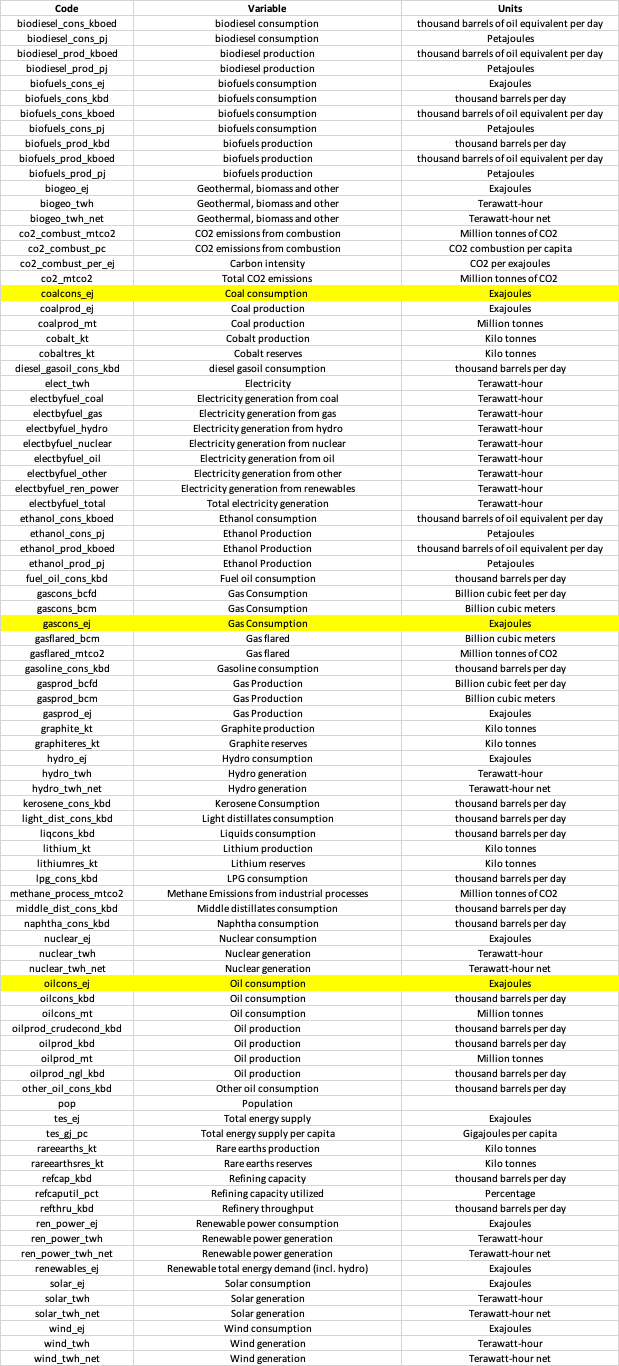

In [ ]:
df_prices

Add Gas Prices
- US dollars per million Btu

In [ ]:
df_gas = pd.read_excel('data/Q3/Gas_prices.xlsx')

In [ ]:
df_gas = df_gas[['Year', 'UK\nNBP3', 'Netherlands TTF3']]

In [ ]:
df_gas

For earlier years, UK NBP prices are used due to limited availability of TTF data; from year 2005 onward, TTF prices are employed as the dominant European benchmark.

In [ ]:
df_gas = df_gas.replace("-", np.nan)
df_gas["UK\nNBP3"] = pd.to_numeric(df_gas["UK\nNBP3"])
df_gas["Netherlands TTF3"] = pd.to_numeric(df_gas["Netherlands TTF3"])
df_gas["gas_prices"] = df_gas["Netherlands TTF3"].fillna(df_gas["UK\nNBP3"])
df_gas = df_gas.drop(columns=["UK\nNBP3", "Netherlands TTF3"])
df_gas["ttf_price"] = df_gas["Year"] >= 2005
df_gas

In [ ]:
df_prices = df_prices.merge(
    df_gas[["Year", "gas_prices", 'ttf_price']],
    on="Year",
    how="left"
)

Add Oil Prices
- US dollars per barrel

In [ ]:
df_oil = pd.read_excel('data/Q3/Oil_prices.xlsx')

In [ ]:
df_oil = df_oil.replace("-", np.nan)
df_oil = df_oil.rename(columns = {'Brent':'oil_prices'})
df_oil

In [ ]:
df_prices = df_prices.merge(
    df_oil[["Year", "oil_prices"]],
    on="Year",
    how="left"
)

Add Coal Prices
- US dollars per tonne

In [ ]:
df_coal = pd.read_excel('data/Q3/Coal_prices.xlsx')

In [ ]:
df_coal = df_coal.rename(columns = {'Northwest Europe3':'coal_prices'})
df_coal

In [ ]:
df_prices = df_prices.merge(
    df_coal[["Year", "coal_prices"]],
    on="Year",
    how="left"
)

In [ ]:
df_prices

In [ ]:
df_prices.isna().any(axis=1).sum()

## Eurostats consumptions (Q2)

In [ ]:
# Read all CSV files from the 'data' directory
data_dir = 'data/Q2'
files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Read all CSV files into DataFrames, keep track of source filename
dfs = []
for fname in files:
    fpath = os.path.join(data_dir, fname)
    df = pd.read_csv(fpath, sep=',')
    df['source_file'] = fname  # add column for original filename
    dfs.append(df)


df = pd.concat(dfs, ignore_index=True, sort=False)
df = df[df['Energy balance'].apply(lambda x: len(str(x).split(" - ")) >= 4)]

# Display basic information about the merged dataset
print("Merged dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()


### 1. EDA

In [ ]:
print("\nUnique countries:")
print(df['Geopolitical entity (reporting)'].unique())

In [ ]:
print("\nTime period range:")
print(f"From {df['TIME_PERIOD'].min()} to {df['TIME_PERIOD'].max()}")

In [ ]:
df.columns

In [ ]:
df['Energy balance'].unique()

### 2. Data Preprocessing

In [ ]:
df['OBS_VALUE'] = pd.to_numeric(df['OBS_VALUE'], errors='coerce')

# Filter out rows with missing values
df_clean = df[df['OBS_VALUE'].notna() & (df['OBS_VALUE'] > 0)].copy()

# Extract sector as the second part of 'Energy balance', subsector as the third part
def extract_sector(energy_balance):
    try:
        parts = str(energy_balance).split(" - ")
        return parts[1].strip() if len(parts) > 1 else "Other"
    except IndexError:
        return "Other"

def extract_subsector(energy_balance):
    try:
        parts = str(energy_balance).split(" - ")
        return parts[2].strip() if len(parts) > 2 else "Other"
    except IndexError:
        return "Other"

df_clean['sector'] = df_clean['Energy balance'].apply(extract_sector)
df_clean['sub_sector'] = df_clean['Energy balance'].apply(extract_subsector)

# Display the distribution of sectors and subsectors
print("Sector distribution:")
print(df_clean['sector'].value_counts())

print("\nSubSector distribution:")
print(df_clean['sub_sector'].value_counts())

In [ ]:
def map_to_fossil_fuel_type(row):
    fossil_fuel_type = row['source_file'].split('_')[1].strip()
    return fossil_fuel_type

df_clean['fossil_fuel_type'] = df_clean.apply(map_to_fossil_fuel_type, axis=1)

def map_to_consumption_type(row):
    consumption_type = row['Energy balance'].split(' - ')[-1].strip()
    return consumption_type

df_clean['consumption_type'] = df_clean.apply(map_to_consumption_type, axis=1)

In [ ]:
df_clean = df_clean[['TIME_PERIOD', 'sector', 'sub_sector', 'OBS_VALUE',
'unit', 'Unit of measure',
'Geopolitical entity (reporting)', 'geo', 'fossil_fuel_type', 'consumption_type']]

## Eurostats renweables (Q4)

In [ ]:
eurostat_shr_renewable_filepath = 'data/Q4/eurostat_share_of_energy_renewables.xlsx'

In [ ]:
def read_file(filepath, sheetname):
  return pd.read_excel(filepath, sheet_name=sheetname, skiprows= 8, engine='openpyxl')

In [ ]:
def clean_data(df):
  # ======Cleaning column names================
  df = df.rename(columns={'TIME': 'Country'})
  df = df[df['Country'] != 'GEO (Labels)']

  valid_cols = [col for col in df.columns if not col.startswith('Unnamed:')]
  df_clean = df[valid_cols]

  # Transforming to "Long Format" for plotting
  df_long = df_clean.melt(id_vars=['Country'], var_name='Year', value_name='Share')

  # Converting values to numeric (handling ':' as NaN)
  df_long['Share'] = pd.to_numeric(df_long['Share'], errors='coerce')
  df_long['Year'] = pd.to_numeric(df_long['Year'])

  #Removing Kosovo and additional details from df
  df_long = df_long[(df_long['Country'] != 'Kosovo*') & (df_long['Country'] != 'Special value') & (df_long['Country'] != ':')]

  return df_long

# Q1: How has the share of fossil fuels in Europe’s total energy supply changed from 1985 to today? (Philipp)

- Data defined in "Data Loading and Preprocessing/Energy Institute" above

In [ ]:
df_developement_fossil = df_energy_institute.copy()

In [ ]:
# print available columns
print(list(df_developement_fossil.columns))

## Current state and change in consumption of fossil fuels

This section shows how European countries consume fossil fuels, focusing on coal, gas, and oil, with Austria highlighted for comparison. Overall, fossil fuel use has decreased since 1985. Gas consumption still grew until around 2005 and started to decline since then. Coal had the largest decline overall.

Germany consumes the most coal, gas, and oil, while Poland relies heavily on coal and Italy on gas. Some countries specialize in specific fuels, such as Poland with coal or France with nuclear electricity. Austria ranks at the lower end of fossil fuel consumption among these countries, mainly using oil, but follows the same downward trend as the others.

When looking at fossil fuel consumption per gdp the two largest consumers Germany and France are only at the lower middle. Austria is found at this level as well.

### Individual countries (top 10 gdp and austria)

In [ ]:
# get top 10 countries 2024 per gdp
top10_countries_2024_gdp = df_developement_fossil[df_developement_fossil['Year'] == 2024].nlargest(10, 'gdp_2024')['Country']
df_developement_fossil_top10_gdp = df_developement_fossil[df_developement_fossil['Country'].isin(top10_countries_2024_gdp)]

In [ ]:
# individual fossil fuels
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

sns.lineplot(
    data=df_developement_fossil_top10_gdp,
    x="Year", y="coalcons_ej",
    hue="Country",
    ax=axes[0]
)
# austria
sns.lineplot(
    data=df_developement_fossil.query("Country == 'Austria'"),
    x="Year", y="coalcons_ej",
    color="tab:red",
    linewidth=2,
    linestyle='--',
    label="Austria",
    ax=axes[0]
)
axes[0].set_title("Coal consumption")

sns.lineplot(
    data=df_developement_fossil_top10_gdp,
    x="Year", y="gascons_ej",
    hue="Country",
    ax=axes[1]
)
# austria
sns.lineplot(
    data=df_developement_fossil.query("Country == 'Austria'"),
    x="Year", y="gascons_ej",
    color="tab:red",
    linewidth=2,
    linestyle='--',
    label="Austria",
    ax=axes[1]
)
axes[1].set_title("Gas consumption")

sns.lineplot(
    data=df_developement_fossil_top10_gdp,
    x="Year", y="oilcons_ej",
    hue="Country",
    ax=axes[2]
)
# austria
sns.lineplot(
    data=df_developement_fossil.query("Country == 'Austria'"),
    x="Year", y="oilcons_ej",
    color="tab:red",
    linewidth=2,
    linestyle='--',
    label="Austria",
    ax=axes[2]
)
axes[2].set_title("Oil consumption")

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

# remove axis legends
for ax in axes:
    ax.legend_.remove()

plt.tight_layout()


In [ ]:
# create Austria-only dataset
df_austria = df_developement_fossil.query("Country == 'Austria'")

# plot all three fuels on one chart
plt.figure(figsize=(6, 4))

sns.lineplot(data=df_austria, x="Year", y="coalcons_ej", label="Coal")
sns.lineplot(data=df_austria, x="Year", y="gascons_ej", label="Gas")
sns.lineplot(data=df_austria, x="Year", y="oilcons_ej", label="Oil")

plt.title("Austria: Individual Fossil Fuel Consumption")
plt.ylabel("Consumption (EJ)")
plt.legend()
plt.tight_layout()

In [ ]:
# total fossil fuel
sns.lineplot(data=df_developement_fossil_top10_gdp, x="Year", y="fossil_cons_ej", hue="Country")
# austria
sns.lineplot(
    data=df_developement_fossil.query("Country == 'Austria'"),
    x="Year", y="fossil_cons_ej",
    color="tab:red",
    linewidth=2,
    linestyle='--',
    label="Austria"
)
plt.title("Total fossil fuel consumption")

### All countries in total

In [ ]:
# lineplot of all three fossil fuels in total
events = {
    1997: "Kyoto Protocol",
    2008: "Financial Crisis",
    2011: "Fukushima",
    2015: "Paris Agreement",
    2020: "COVID-19",
    2022: "Russia–Ukraine War"
}

df_developement_fossil_agg = df_developement_fossil.groupby("Year").sum().reset_index()

plt.figure(figsize=(10, 7))

sns.lineplot(data=df_developement_fossil_agg, x="Year", y="coalcons_ej", label="Coal")
sns.lineplot(data=df_developement_fossil_agg, x="Year", y="gascons_ej", label="Gas")
sns.lineplot(data=df_developement_fossil_agg, x="Year", y="oilcons_ej", label="Oil")

# Add event lines and annotations
y_max = df_developement_fossil_agg[
    ["coalcons_ej", "gascons_ej", "oilcons_ej"]
].max().max()

for year, label in events.items():
    plt.axvline(x=year, linestyle="--", alpha=0.5, color="blue")
    plt.text(
        x=year,
        y=y_max * 0.95,
        s=label,
        rotation=90,
        verticalalignment="top",
        horizontalalignment="right",
        fontsize=11
    )

plt.xlabel("Year")
plt.ylabel("Energy Consumption (EJ)")
plt.title("Global Fossil Fuel Consumption with Major Events")
plt.legend()
plt.tight_layout()

In [ ]:
# filter for 2024
df_2024 = df_developement_fossil[df_developement_fossil['Year'] == 2024]
# get countries sorted by share_fossil descending
country_order = df_2024.sort_values("fossil_cons_ej", ascending=False)["Country"]
sns.barplot(data=df_developement_fossil[df_developement_fossil.Year==2024], x="fossil_cons_ej", y="Country", order=country_order)
plt.title("Total fossil fuel consumption in Europe (2024)")

In [ ]:
# fossil fuel consumption / gdp
df_developement_fossil2024 = df_developement_fossil[df_developement_fossil['Year'] == 2024].copy()
df_developement_fossil2024['fossil_per_gdp'] = df_developement_fossil2024['fossil_cons_ej']*278 / df_developement_fossil2024['gdp_2024'] #278 -> twh
country_order = df_developement_fossil2024.sort_values("fossil_per_gdp", ascending=False)["Country"]
sns.barplot(data=df_developement_fossil2024, y="Country", x="fossil_per_gdp", hue="tes_ej", palette="flare", order=country_order)

## Share of fossil fuels per country

This section focuses on the share of fossil fuels in total energy supply (tes_ej). A bar plot illustrates the fossil fuel share by country in 2024, while a line chart shows how this share has developed over time for the top GDP countries. Countries such as Cyprus, North Macedonia, and Poland have the highest reliance on fossil fuels in their energy mix. In contrast, northern countries like Norway and Sweden show the lowest fossil fuel shares, along with France, which relies heavily on nuclear energy for electricity generation.

In [ ]:
# filter for 2024
df_2024 = df_developement_fossil[df_developement_fossil['Year'] == 2024]

# sort countries
country_order = df_2024.sort_values("share_fossil", ascending=False)["Country"]

# create palette: light gray for all, strong color for Austria
palette = {
    c: "tab:red" if c == "Austria" else "lightgray"
    for c in country_order
}

sns.barplot(
    data=df_2024,
    y="Country",
    x="share_fossil",
    hue="Country",
    order=country_order,
    palette=palette,
    legend=False
)

plt.title("Share of fossil fuels in 2024")
plt.tight_layout()
plt.show()


In [ ]:
# share of fossil fuels for top 10 countries (gdp)
ax = sns.lineplot(data=df_developement_fossil_top10_gdp, x="Year", y="share_fossil", hue="Country")
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

In [ ]:
# map of shares in 20204
fig = px.choropleth(
    df_developement_fossil2024,
    locations="ISO3166_alpha3",
    locationmode="ISO-3",
    color="share_fossil",
    hover_name="Country",
    projection="natural earth"
)

# center to europe
fig.update_geos(
    center=dict(lat=54, lon=15),
    projection_scale=3.5,
    showcoastlines=True,
    showcountries=True,
    domain=dict(x=[0, 1], y=[0, 1])
)

## Reduction of fossil fuels

We'll analyze both absolute and relative contributions to fossil fuel reduction across European countries.
The reduction is calculated as the difference between the baseline year 2005 (where all fossil fuels started to decline) and the most recent year in our data 2024.

Large consumers such as Germany and the United Kingdom achieved the highest absolute reductions in fossil fuel consumption, reflecting their historically high usage, while Turkey expanded fossil fuel use significantly over the same period. Northern European countries performed particularly well in reducing their consumption, and Austria ranks around the middle in terms of relative reduction, though its absolute decrease is too small to stand out.

In [ ]:
# Calculate fossil fuel reduction by country
baseline_year = 2005
recent_year = 2024

# Get fossil fuel consumption for baseline and recent years
df_baseline = df_energy_institute[df_energy_institute['Year'] == baseline_year][['Country', 'fossil_cons_ej']].copy()
df_recent = df_energy_institute[df_energy_institute['Year'] == recent_year][['Country', 'fossil_cons_ej']].copy()

# Merge to calculate reduction
df_reduction = df_baseline.merge(df_recent, on='Country', suffixes=('_baseline', '_recent'), how='inner')
df_reduction['absolute_reduction_ej'] = df_reduction['fossil_cons_ej_baseline'] - df_reduction['fossil_cons_ej_recent']
df_reduction['percentage_reduction'] = (df_reduction['absolute_reduction_ej'] / df_reduction['fossil_cons_ej_baseline']) * 100

# Calculate Europe total reduction
europe_baseline = df_baseline['fossil_cons_ej'].sum()
europe_recent = df_recent['fossil_cons_ej'].sum()
europe_total_reduction = europe_baseline - europe_recent

# Calculate each country's contribution to total reduction
df_reduction['contribution_to_total_reduction_pct'] = (df_reduction['absolute_reduction_ej'] / europe_total_reduction) * 100

# Sort by absolute reduction
df_reduction_sorted = df_reduction.sort_values('absolute_reduction_ej', ascending=False)

print(f"Europe total fossil fuel reduction ({baseline_year} to {recent_year}): {europe_total_reduction:.2f} EJ")
print(f"Countries by absolute reduction:")
print(df_reduction_sorted[['Country', 'absolute_reduction_ej', 'percentage_reduction', 'contribution_to_total_reduction_pct']].to_string(index=False))

In [ ]:
# Visualize country contributions, highlighting Austria

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Find Austria's entry
austria_row = df_reduction[df_reduction['Country'] == 'Austria']

# Prepare top 15 plus Austria if not already included
top15 = df_reduction_sorted.head(15)
if 'Austria' not in top15['Country'].values and not austria_row.empty:
    # Append Austria row to the bottom
    top15 = pd.concat([top15, austria_row], ignore_index=True)

# Determine highlight mask for Austria
highlight_mask = top15['Country'] == 'Austria'

# Plot 1: Absolute reduction (top 15 + Austria if needed)
colors = ['gold' if is_at else 'steelblue' for is_at in highlight_mask]
bars1 = axes[0].barh(range(len(top15)), top15['absolute_reduction_ej'], color=colors, edgecolor='black')
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15['Country'])
axes[0].set_xlabel('Absolute Reduction (EJ)')
axes[0].set_title(f'Top Countries by Absolute Fossil Fuel Reduction (highlighting Austria)\n({baseline_year} to {recent_year})')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Plot 2: Contribution to total reduction (%)
colors2 = ['gold' if is_at else 'coral' for is_at in highlight_mask]
bars2 = axes[1].barh(range(len(top15)), top15['contribution_to_total_reduction_pct'], color=colors2, edgecolor='black')
axes[1].set_yticks(range(len(top15)))
axes[1].set_yticklabels(top15['Country'])
axes[1].set_xlabel('Contribution to Total Reduction (%)')
axes[1].set_title(f'Contribution to Europe\'s Total Fossil Fuel Reduction (highlighting Austria)\n({baseline_year} to {recent_year})')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

# Add legend for Austria highlight
from matplotlib.patches import Patch
custom_legend = [
    Patch(facecolor='gold', edgecolor='black', label='Austria'),
    Patch(facecolor='steelblue', edgecolor='black', label='Other (Abs.Red.)'),
    Patch(facecolor='coral', edgecolor='black', label='Other (Contribution)')
]
axes[0].legend([custom_legend[0], custom_legend[1]], ['Austria', 'Other'], loc='lower right')
axes[1].legend([custom_legend[0], custom_legend[2]], ['Austria', 'Other'], loc='lower right')

plt.tight_layout()

In [ ]:
# Scatter plot: Absolute reduction vs Percentage reduction, highlighting Austria

plt.figure(figsize=(12, 8))

# Create a mask for Austria
is_austria = df_reduction['Country'] == 'Austria'

# Plot other countries
plt.scatter(
    df_reduction.loc[~is_austria, 'absolute_reduction_ej'],
    df_reduction.loc[~is_austria, 'percentage_reduction'],
    s=100, alpha=0.6, edgecolors='black', linewidth=1, label='Other Countries'
)

# Plot Austria with a different color and zorder for emphasis
plt.scatter(
    df_reduction.loc[is_austria, 'absolute_reduction_ej'],
    df_reduction.loc[is_austria, 'percentage_reduction'],
    s=180, color='gold', edgecolors='black', linewidth=1.5, label='Austria', zorder=5
)

# Annotate top contributors
top_contributors = df_reduction_sorted.head(10)
for _, row in top_contributors.iterrows():
    color = 'gold' if row['Country'] == 'Austria' else 'black'
    fontweight = 'bold' if row['Country'] == 'Austria' else 'normal'
    plt.annotate(
        row['Country'],
        (row['absolute_reduction_ej'], row['percentage_reduction']),
        fontsize=10, ha='center', color=color, fontweight=fontweight,
        zorder=6 if row['Country'] == 'Austria' else 4
    )

plt.xlabel('Absolute Reduction (EJ)', fontsize=12)
plt.ylabel('Percentage Reduction (%)', fontsize=12)
plt.title(f'Country Performance: Absolute vs Percentage Fossil Fuel Reduction\n({baseline_year} to {recent_year})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Electricity
This section focusses on the electricity generation in detail, as its by the far the most used sector of fossil fuels and energy in general.

### Electricity generation developement by fuel
Here, a stacked area chart illustrates the use of all energy sources across Europe since 1985. Overall electricity generation has remained relatively stable since around 2005. The chart highlights the declining importance of fossil fuels as renewable energy sources have grown. In addition to fossil fuels and renewables, nuclear energy continues to play an important role in the European energy mix.

In [ ]:
df_total_sum = df_developement_fossil.groupby('Year')[[
    'electbyfuel_ren_power',
    'electbyfuel_hydro',
    'electbyfuel_gas',
    'electbyfuel_coal',
    'electbyfuel_nuclear',
    'electbyfuel_oil',
    'electbyfuel_other',
    'electbyfuel_total'
]].sum()
colors = [
    "#2ca02c",  # Renewables - green
    "#1f77b4",  # Hydro - blue
    "#ff7f0e",  # Gas - orange
    "#d62728",  # Coal - red
    "#9467bd",  # Nuclear - purple
    "#8c564b",  # Oil - brown
    "#7f7f7f"   # Other - gray
]
# create stackplot
plt.stackplot(
    df_total_sum.index,
    df_total_sum.electbyfuel_ren_power,
    df_total_sum.electbyfuel_hydro,
    df_total_sum.electbyfuel_gas,
    df_total_sum.electbyfuel_coal,
    df_total_sum.electbyfuel_nuclear,
    df_total_sum.electbyfuel_oil,
    df_total_sum.electbyfuel_other,
    labels=['Renewables', 'Hydro', 'Gas', 'Coal', 'Nuclear', 'Oil', 'Other'],
    colors=colors
)
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Electricity Generation (TWh)")
plt.title("Total electricity generation in Europe by fuel since 1985")

### Electricity generation for top 10 countries by electricty generation for every fuel
Overall in the countries with the highest electricity generation, fossil fuels are declining, while renewables are rising. In nuclear energy the strategies of different countries are different. While france uses a lot of nuclear energy, germany decided to completly end nuclear energy.

Unfortunately, the Statistical Review of World Energy doesn't include electricity data for Austria.

In [ ]:
# top 10 countries by electricty production
top10_countries_2024 = df_developement_fossil[df_developement_fossil['Year'] == 2024].nlargest(10, 'elect_twh')['Country']
df_developement_fossil_top10 = df_developement_fossil[df_developement_fossil['Country'].isin(top10_countries_2024)]

In [ ]:
# coal
sns.lineplot(data=df_developement_fossil_top10, x="Year", y="electbyfuel_coal", hue="Country")
plt.title("Electricity generation from coal for top 10 countries by electricity generation since 1985")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(which="both")

In [ ]:
# gas
sns.lineplot(data=df_developement_fossil_top10, x="Year", y="electbyfuel_gas", hue="Country")
plt.title("Electricity generation from gas for top 10 countries by electricity generation since 1985")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(which="both")

In [ ]:
# oil
sns.lineplot(data=df_developement_fossil_top10, x="Year", y="electbyfuel_oil", hue="Country")
plt.title("Electricity generation from oil for top 10 countries by electricity generation since 1985")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(which="both")

In [ ]:
# nuclear
sns.lineplot(data=df_developement_fossil_top10, x="Year", y="electbyfuel_nuclear", hue="Country")
plt.title("Electricity generation from nuclear for top 10 countries by electricity generation since 1985")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(which="both")

In [ ]:
# renweables
sns.lineplot(data=df_developement_fossil_top10, x="Year", y="electbyfuel_ren_power", hue="Country")
plt.title("Electricity generation from renewables (excluding hydro) for top 10 countries by electricity generation since 1985")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(which="both")

In [ ]:
# Hydro
sns.lineplot(data=df_developement_fossil_top10, x="Year", y="electbyfuel_hydro", hue="Country")
plt.title("Electricity generation from hydro for top 10 countries by electricity generation since 1985")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(which="both")

### Interactive Map of primary energies
The interactive map shows the primary energy sources across European countries over time. Coal was the dominant electricity source for most countries for many years and remains primary in several, but in recent years gas and renewable energy have started to play an increasingly important role.

In [ ]:
# get the primary energy source
fuel_cols = [
    'electbyfuel_coal',
    'electbyfuel_gas',
    'electbyfuel_oil',
    'electbyfuel_nuclear',
    'electbyfuel_hydro',
    'electbyfuel_ren_power'
]

df_developement_fossil['top_fuel'] = df_developement_fossil[fuel_cols].idxmax(axis=1)
df_developement_fossil2024 = df_developement_fossil[df_developement_fossil['Year'] == 2024]

In [ ]:
color_map = {
    "electbyfuel_coal": "brown",
    "electbyfuel_oil": "black",
    "electbyfuel_gas": "orange",
    "electbyfuel_nuclear": "purple",
    "electbyfuel_ren_power": "green"
}

fig = px.choropleth(
    df_developement_fossil,
    locations="ISO3166_alpha3",
    locationmode="ISO-3",
    color="top_fuel",
    hover_name="Country",
    animation_frame="Year",
    projection="natural earth",
    color_discrete_map=color_map
)

# center to europe
fig.update_geos(
    center=dict(lat=54, lon=15),
    projection_scale=3.5,
    showcoastlines=True,
    showcountries=True,
    domain=dict(x=[0, 1], y=[0, 1])
)


fig.update_layout(
    title=dict(
        text="Primary Electricity Source by Country",
        x=0.5,
        xanchor="center"
    ),
    margin=dict(l=0, r=0, t=60, b=0),
    legend_title_text="Primary fuel",
    font=dict(size=13),
    paper_bgcolor="white",
    plot_bgcolor="white"
)


fig.show()

# Q2: Which sectors account for the largest share of fossil-fuel consumption in Europe?
- Data defined in "Data Loading and Preprocessing/Eurostats consumptions" above

## 1: Which sectors account for the largest share of fossil-fuel consumption in Europe, and how has their contribution shifted over time?

In [ ]:
selected_year = 2023
df_year = df_clean[df_clean['TIME_PERIOD'] == selected_year]

for fuel in df_year['fossil_fuel_type'].unique():
    df_fuel = df_year[df_year['fossil_fuel_type'] == fuel]
    agg = (
        df_fuel.groupby(['sector', 'sub_sector'])['OBS_VALUE']
        .sum()
        .reset_index()
    )
    fig = px.sunburst(
        agg,
        path=['sector', 'sub_sector'],
        values='OBS_VALUE',
        title=f"Sunburst Chart: {fuel.capitalize()} Consumption by Sector & Subsector ({selected_year})",
        color='sector'
    )
    fig.show()

In [ ]:
# For each fossil_fuel_type, plot the stackplot of *subsector* contributions over years
fossil_fuel_types = df_clean['fossil_fuel_type'].unique()

for fuel in fossil_fuel_types:
    subset = df_clean[df_clean['fossil_fuel_type'] == fuel]
    # Get unit information
    unit_info = subset['Unit of measure'].iloc[0] if not subset['Unit of measure'].empty else 'units'
    
    # Group and sum OBS_VALUE by year and sub_sector
    sub_sector_year_consumption = (
        subset.groupby(['TIME_PERIOD', 'sub_sector'])['OBS_VALUE']
        .sum()
        .reset_index()
    )
    # Pivot to wide format for stackplot
    pivot = sub_sector_year_consumption.pivot_table(
        index='TIME_PERIOD', columns='sub_sector', values='OBS_VALUE', fill_value=0
    )
    # Order subsectors by total consumption for readability
    sub_sector_order = pivot.sum(axis=0).sort_values(ascending=False).index
    pivot = pivot[sub_sector_order]
    # Ensure years are sorted numerically
    pivot = pivot.sort_index()
    
    # Create figure with two subplots: absolute and percentage
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot 1: Absolute values (stackplot)
    ax1.stackplot(
        pivot.index, 
        pivot.values.T, 
        labels=pivot.columns,
        alpha=0.8
    )
    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title="Subsector")
    ax1.set_title(f"{fuel.capitalize()} Consumption by Subsector in Europe Over Time (Absolute Values)")
    ax1.set_xlabel("Year")
    ax1.set_ylabel(f"Consumption ({unit_info})")
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Percentage contribution
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
    ax2.stackplot(
        pivot_pct.index,
        pivot_pct.values.T,
        labels=pivot_pct.columns,
        alpha=0.8
    )
    ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title="Subsector")
    ax2.set_title(f"{fuel.capitalize()} Consumption by Subsector in Europe Over Time (Percentage Share)")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Percentage (%)")
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


### Sectoral Contributions to Fossil-Fuel Consumption in Europe

- **Oil**
  - Largest share comes from the **transport sector**, especially **road transport**.
  - The share of transport in oil consumption has **increased over time**.
  - Industry and other sectors play a **smaller and declining role** in oil use.

- **Solid Fuels**
  - Consumption is **concentrated in the industrial sector**, particularly:
    - non-metallic minerals  
    - iron and steel  
    - chemical and petrochemical industries
  - Both absolute and relative consumption of solid fuels in industry has **declined sharply since the 1990s**.
  - This reflects **structural industrial change and decarbonisation policies**.

- **Gas**
  - The largest share lies in **“other sectors,” dominated by households**.
  - Gas is primarily used for **heating and residential energy needs**.
  - The sectoral structure of gas consumption remains **relatively stable over time**, despite fluctuations in total demand.

- **Overall Interpretation**
  - Europe shows a **transport-driven oil profile**.
  - Solid fuels are **shrinking but remain industry-centred**.
  - Gas consumption is **household-centred and structurally persistent**.
  - Sectoral transitions are occurring at **different speeds across fuel types**.

## 2. How do Western vs. Eastern European countries differ in sectoral fossil-fuel consumption?

In [ ]:
western_countries = [
    "Austria", "Belgium", "France", "Germany", "Netherlands", "Switzerland",
    "Luxembourg", "Ireland", "United Kingdom", "Monaco", "Liechtenstein"
]
eastern_countries = [
    "Albania", "Belarus", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Czechia",
    "Estonia", "Hungary", "Kosovo", "Latvia", "Lithuania", "Moldova", "North Macedonia", 
    "Poland", "Romania", "Russia", "Serbia", "Slovakia", "Slovenia", "Ukraine", "Montenegro"
]

def region_from_country(country):
    if country in western_countries:
        return "Western Europe"
    elif country in eastern_countries:
        return "Eastern Europe"
    else:
        return "Other"

df_clean['region'] = df_clean['Geopolitical entity (reporting)'].apply(region_from_country)

# Group by year, region, sector, fuel and sum consumption for time-series analysis
sector_region_year_agg = (
    df_clean[df_clean['region'].isin(['Western Europe', 'Eastern Europe'])]
    .groupby(['TIME_PERIOD', 'region', 'sector', 'fossil_fuel_type'])['OBS_VALUE']
    .sum()
    .reset_index()
)

# Get the most common unit for each fuel type
fuel_unit_map = (
    df_clean[df_clean['region'].isin(['Western Europe', 'Eastern Europe'])]
    .groupby('fossil_fuel_type')['unit']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else '')
    .to_dict()
)

for fuel in sector_region_year_agg['fossil_fuel_type'].unique():
    plot_data = sector_region_year_agg[sector_region_year_agg['fossil_fuel_type'] == fuel]
    sectors = sorted(plot_data['sector'].unique())
    regions = ['Western Europe', 'Eastern Europe']
    fuel_unit = fuel_unit_map.get(fuel, "")

    n_sectors = len(sectors)
    ncols = 2
    nrows = math.ceil(n_sectors / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4*nrows), sharex=True)
    axes = axes.flatten() if n_sectors > 1 else [axes]

    handles_labels = dict()
    for idx, sector in enumerate(sectors):
        ax = axes[idx]
        for region in regions:
            series = plot_data[(plot_data['sector'] == sector) & (plot_data['region'] == region)]
            series = series.sort_values('TIME_PERIOD')
            ax.plot(series['TIME_PERIOD'], series['OBS_VALUE'], marker='o', label=region)
        ax.set_title(f"{sector} Sector")
        # Always set the X and Y label (year and consumption) for each subplot
        ax.set_xlabel("Year")
        ax.set_ylabel(f"Consumption ({fuel_unit})")
        # Only collect legend handles from the first subplot
        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            handles_labels = {"handles": handles, "labels": labels}
        ax.grid(True, alpha=0.3)
        # Force x-tick labels (year) to appear for every subplot
        ax.tick_params(axis='x', labelbottom=True)

    # If there are unused subplots, hide them
    for j in range(len(sectors), len(axes)):
        fig.delaxes(axes[j])

    # Place one legend in the figure as a whole
    if handles_labels:
        fig.legend(handles_labels["handles"], handles_labels["labels"], title="Region", loc='upper right')
    fig.suptitle(f"{fuel.capitalize()} Consumption Over Time by Sector\n(Western vs Eastern Europe)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Western vs. Eastern Europe: Sectoral Fossil-Fuel Consumption

- **Gas**
    - **Industry**
        - Western Europe: **higher and more stable** gas use.
        - Eastern Europe: **lower and declining**, reflecting slower gas substitution.
    - **Transport**
        - Both regions: **very limited use**; minor, recent uptake only in the West.
    - **Other sectors (households & services)**
        - Western Europe: **structurally gas-reliant and larger scale**.
        - Eastern Europe: **smaller but steadier**, indicating slower gas penetration.

- **Oil**
    - **Industry**
        - Western Europe: **gradual decline from a stable baseline**.
        - Eastern Europe: **sharp drop in early 1990s**, then flat at lower levels.
    - **Transport**
        - Western Europe: **high and rising until ~2018**, then stabilizing/declining.
        - Eastern Europe: **lower but steadily growing from a small base**.
    - **Other sectors**
        - Western Europe: **clear long-term reduction**.
        - Eastern Europe: **low residual levels**, slower decline.

- **Coal**
    - **Industry**
        - Eastern Europe: **much higher historical dependence**, gradual decline.
        - Western Europe: **lower and steadily decreasing**.
    - **Transport**
        - Both regions: **negligible and phased out earlier in the West**.
    - **Other sectors**
        - Eastern Europe: **higher starting point, slower phase-out**.
        - Western Europe: **faster and deeper decline**.

### **Overall Pattern**
- Western Europe: **gas-heavy system + faster coal and oil phase-down**.
- Eastern Europe: **legacy coal dependence + slower household transition**, but **long-term convergence trend**.

## 3. Which sectors are driving the decline/growth of fossil fuel consumption in Europe?

In [ ]:
# Identify the major fossil fuel types present
main_fossil_fuels = df_clean['fossil_fuel_type'].unique()

# For each fuel type, plot only the top 5 subsectors in the same plot
for fuel in main_fossil_fuels:
    df_fuel = df_clean[df_clean['fossil_fuel_type'] == fuel]
    # Calculate total consumption per subsector (sum over all years)
    subsector_totals = (
        df_fuel.groupby('sub_sector')['OBS_VALUE']
        .sum()
        .sort_values(ascending=False)
    )
    top5_subsectors = subsector_totals.head(5).index.tolist()
    years = np.sort(df_fuel['TIME_PERIOD'].unique())

    plt.figure(figsize=(14, 6))
    for subsector in top5_subsectors:
        subsector_df = df_fuel[df_fuel['sub_sector'] == subsector]
        subsector_yearly = subsector_df.groupby('TIME_PERIOD')['OBS_VALUE'].sum().reindex(years)
        plt.plot(years, subsector_yearly, marker='o', label=subsector)
    plt.title(f"Top 5 Subsectors for {fuel.capitalize()} Consumption Over Time")
    plt.xlabel("Year")
    plt.ylabel(f"Consumption ({df_fuel['unit'].iloc[0]})")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Subsector")
    plt.tight_layout()
    plt.show()


#### Oil — Growth Driven Mainly by Transport & Industry
- **Road transport is the dominant growth driver** — sustained long-term increase with only temporary dips (e.g., COVID), showing strong structural dependence on oil.
- **Chemical & petrochemical shows moderate upward growth**, reflecting persistent industrial demand.
- **Households and construction decline gradually**, indicating efficiency gains and fuel switching away from oil.
- **Commercial & public services trend downward**, contributing modestly to overall oil reduction outside transport.

#### Coal — Broad and Structural Decline
- **Households drive the steepest drop** — rapid phase-out of coal for heating across decades.
- **Iron & steel and non-metallic minerals decline significantly**, driven by industrial modernization and decarbonisation policies.
- **Commercial/public services and chemicals also fall**, reinforcing the system-wide contraction.
- The decline in solid fuels is **broad-based across sectors**, not concentrated in a single activity.

#### Gas — Growth Concentrated in Buildings & Light Industry
- **Households are the primary growth driver**, reflecting continued reliance on gas for residential heating.
- **Commercial & public services expand steadily**, showing substitution away from coal and oil in buildings.
- **Chemical & petrochemical remains stable to mildly increasing**, supporting industrial processes.
- **Non-metallic minerals and food industries show modest increases** with some recent volatility.
- Recent dips suggest **efficiency gains and early transition effects**, but gas remains **household-centric**.

#### Overall Insight
- **Decline is led by coal-intensive sectors** — households and heavy industry.
- **Growth is driven by transport for oil and heating in households/services for gas**.
- Europe’s transition reflects **fuel switching (coal → gas) rather than uniform reductions**, while **transport oil demand remains resilient**.

# Q3: What effect does the change in price of fossil fuels have on their use?
- Data defined in "Data Loading and Preprocessing/Energy Institute" above

## Fossil Fuel Consumption in Europe

### Correlation between fossil fuel consumption and prices

In [ ]:
correlation_matrix = df_prices[['coalcons_ej', 'gascons_ej', 'oilcons_ej', 'coal_prices', 'gas_prices', 'oil_prices']].corr()
correlation_matrix

In [ ]:
print(f"Correlation between coal consumption and coal prices: {correlation_matrix.loc['coalcons_ej', 'coal_prices']:.4f}")
print(f"Correlation between gas consumption and gas prices: {correlation_matrix.loc['gascons_ej', 'gas_prices']:.4f}")
print(f"Correlation between oil consumption and oil prices: {correlation_matrix.loc['oilcons_ej', 'oil_prices']:.4f}")

After calculating the correlation matrix and extracting the relevant coefficients, the following relationships between fossil fuel consumption and prices were observed:

- **Coal Consumption vs. Coal Prices**: The correlation coefficient is **-0.0904**. This indicates a very weak negative correlation. Essentially, as coal prices increase, coal consumption tends to decrease slightly, but the relationship is not strong. The value being close to zero suggests that coal price is not a major factor influencing its consumption in the dataset.

- **Gas Consumption vs. Gas Prices**: The correlation coefficient is **-0.0194**. This is an extremely weak negative correlation, even weaker than that for coal. It suggests almost no linear relationship between gas prices and gas consumption. Price changes have a negligible impact on gas consumption based on this data.

- **Oil Consumption vs. Oil Prices**: The correlation coefficient is **-0.0466**. Similar to gas and coal, this indicates a very weak negative correlation. An increase in oil prices is associated with a marginal decrease in oil consumption, but the connection is largely insignificant.

**General Trends and Notable Aspects:**

Across all three fossil fuel types (coal, gas, and oil), the correlation coefficients between consumption and their respective prices are negative but extremely close to zero. This implies that for the European countries in this dataset, over the period considered, changes in the prices of these fossil fuels have a very limited linear impact on their consumption. This could be due to several factors, such as long-term contracts, regulated markets, high inelasticity of demand for essential energy sources, or other geopolitical and economic factors that might exert a stronger influence on consumption patterns than price fluctuations alone.

### Plot the data

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_prices, x='coal_prices', y='coalcons_ej')
plt.title('Coal Consumption vs. Coal Prices')
plt.xlabel('Coal Prices (US dollars per tonne)')
plt.ylabel('Coal Consumption (EJ)')
plt.grid(True)
plt.show()

This scatter plot shows the relationship between coal consumption (in Exajoules, EJ) on the y-axis and coal prices (in US dollars per tonne) on the x-axis. The data points appear to be widely scattered, with no clear or strong linear trend. This visual representation aligns with the calculated correlation coefficient of -0.0904, indicating a very weak negative linear relationship. It suggests that while there might be a slight tendency for coal consumption to decrease as prices increase, the price is not a dominant factor in determining consumption patterns within this dataset.

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_prices, x='gas_prices', y='gascons_ej')
plt.title('Gas Consumption vs. Gas Prices')
plt.xlabel('Gas Prices (US dollars per million Btu)')
plt.ylabel('Gas Consumption (EJ)')
plt.grid(True)
plt.show()

This plot illustrates gas consumption (EJ) against gas prices (US dollars per million Btu). Similar to coal, the scatter plot for gas shows a very dispersed pattern, with no noticeable linear relationship between the two variables. This visual finding is consistent with the extremely weak negative correlation coefficient of -0.0194. The plot effectively demonstrates that gas price fluctuations have a negligible linear impact on gas consumption.

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_prices, x='oil_prices', y='oilcons_ej')
plt.title('Oil Consumption vs. Oil Prices')
plt.xlabel('Oil Prices (US dollars per barrel)')
plt.ylabel('Oil Consumption (EJ)')
plt.grid(True)
plt.show()

This scatter plot displays oil consumption (EJ) versus oil prices (US dollars per barrel). The distribution of data points is also highly scattered, indicating a lack of a strong linear association. This visual observation supports the calculated correlation coefficient of -0.0466, which signifies a very weak negative correlation. The plot confirms that changes in oil prices, like coal and gas, do not strongly or linearly influence oil consumption patterns in the observed data

In [ ]:
plt.figure(figsize=(12, 7))

# Coal Consumption
ax1 = sns.lineplot(data=df_prices, x='Year', y='coalcons_ej', label='Coal Consumption (EJ)', color='blue')
ax1.set_ylabel('Coal Consumption (EJ)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Coal Prices on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_prices, x='Year', y='coal_prices', label='Coal Prices (US$/tonne)', color='red', ax=ax2)
ax2.set_ylabel('Coal Prices (US$/tonne)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Coal Consumption and Prices Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 7))

# Gas Consumption
ax1 = sns.lineplot(data=df_prices, x='Year', y='gascons_ej', label='Gas Consumption (EJ)', color='blue')
ax1.set_ylabel('Gas Consumption (EJ)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Gas Prices on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_prices, x='Year', y='gas_prices', label='Gas Prices (US$/MMBtu)', color='red', ax=ax2)
ax2.set_ylabel('Gas Prices (US$/MMBtu)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Gas Consumption and Prices Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(12, 7))

# Oil Consumption
ax1 = sns.lineplot(data=df_prices, x='Year', y='oilcons_ej', label='Oil Consumption (EJ)', color='blue')
ax1.set_ylabel('Oil Consumption (EJ)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Oil Prices on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_prices, x='Year', y='oil_prices', label='Oil Prices (US$/barrel)', color='red', ax=ax2)
ax2.set_ylabel('Oil Prices (US$/barrel)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Oil Consumption and Prices Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

### Lagged Price Correlations


**Reasoning**:
To create the lagged price variables as requested in the instructions, I will apply the `shift(1)` function to each price column (`coal_prices`, `gas_prices`, `oil_prices`) after grouping the DataFrame by 'Country'. This will generate new columns representing the previous year's price for each country.



In [ ]:
df_prices['lag_coal_prices'] = df_prices.groupby('Country')['coal_prices'].shift(1)
df_prices['lag_gas_prices'] = df_prices.groupby('Country')['gas_prices'].shift(1)
df_prices['lag_oil_prices'] = df_prices.groupby('Country')['oil_prices'].shift(1)
df_prices.head()

In [ ]:
lagged_correlation_matrix = df_prices[['coalcons_ej', 'gascons_ej', 'oilcons_ej', 'lag_coal_prices', 'lag_gas_prices', 'lag_oil_prices']].corr()
print(lagged_correlation_matrix)

print(f"Correlation between coal consumption and lagged coal prices: {lagged_correlation_matrix.loc['coalcons_ej', 'lag_coal_prices']:.4f}")
print(f"Correlation between gas consumption and lagged gas prices: {lagged_correlation_matrix.loc['gascons_ej', 'lag_gas_prices']:.4f}")
print(f"Correlation between oil consumption and lagged oil prices: {lagged_correlation_matrix.loc['oilcons_ej', 'lag_oil_prices']:.4f}")

After calculating the correlation between current fossil fuel consumption and their prices from one year prior (lag-1), the following relationships were observed:

-   **Coal Consumption vs. Lagged Coal Prices**: The correlation coefficient is **-0.0946**. This indicates a very weak negative correlation, similar to the contemporaneous correlation. It suggests that a slight tendency for current coal consumption to decrease as coal prices from the previous year increase, but the relationship remains not strong.

-   **Gas Consumption vs. Lagged Gas Prices**: The correlation coefficient is **-0.0349**. This is an extremely weak negative correlation, similar to the contemporaneous correlation. It suggests almost no linear relationship between current gas consumption and gas prices from the previous year. Price changes a year prior have a negligible impact on current gas consumption based on this data.

-   **Oil Consumption vs. Lagged Oil Prices**: The correlation coefficient is **-0.0516**. Similar to coal and gas, this indicates a very weak negative correlation. An increase in oil prices from the previous year is associated with a marginal decrease in current oil consumption, but the connection is largely insignificant.

**General Trends and Notable Aspects (Time-Lagged):**

Similar to the contemporaneous correlations, the time-lagged correlations between fossil fuel consumption and their respective prices from one year prior are also negative and extremely close to zero across all three fuel types. This reinforces the idea that for the European countries in this dataset, over the period considered, both current and past price changes of these fossil fuels have a very limited linear impact on their consumption. This could be attributed to factors such as demand inelasticity, long-term supply contracts, or other macroeconomic and geopolitical influences that might be stronger drivers of consumption patterns.

## Electricity sector in Europe

### Correlation

In [ ]:
correlation_matrix_e = df_prices[['electbyfuel_coal', 'electbyfuel_gas', 'electbyfuel_oil', 'coal_prices', 'gas_prices', 'oil_prices']].corr()

print(f"Correlation between coal consumption and coal prices: {correlation_matrix_e.loc['electbyfuel_coal', 'coal_prices']:.4f}")
print(f"Correlation between gas consumption and gas prices: {correlation_matrix_e.loc['electbyfuel_gas', 'gas_prices']:.4f}")
print(f"Correlation between oil consumption and oil prices: {correlation_matrix_e.loc['electbyfuel_oil', 'oil_prices']:.4f}")

### Lagged Correlation

In [ ]:
lagged_correlation_matrix_e = df_prices[['electbyfuel_coal', 'electbyfuel_gas', 'electbyfuel_oil', 'lag_coal_prices', 'lag_gas_prices', 'lag_oil_prices']].corr()

print(f"Correlation between coal consumption and lagged coal prices: {lagged_correlation_matrix_e.loc['electbyfuel_coal', 'lag_coal_prices']:.4f}")
print(f"Correlation between gas consumption and lagged gas prices: {lagged_correlation_matrix_e.loc['electbyfuel_gas', 'lag_gas_prices']:.4f}")
print(f"Correlation between oil consumption and lagged oil prices: {lagged_correlation_matrix_e.loc['electbyfuel_oil', 'lag_oil_prices']:.4f}")

### Plots

In [ ]:
plt.figure(figsize=(12, 7))

# Coal Consumption
ax1 = sns.lineplot(data=df_prices, x='Year', y='electbyfuel_coal', label='Electricity generation from coal (TWH)', color='blue')
ax1.set_ylabel('Electricity generation from coal (TWH)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Coal Prices on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_prices, x='Year', y='coal_prices', label='Coal Prices (US$/tonne)', color='red', ax=ax2)
ax2.set_ylabel('Coal Prices (US$/tonne)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Electricity Generation from Coal and Prices Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 7))

# Gas Consumption
ax1 = sns.lineplot(data=df_prices, x='Year', y='electbyfuel_gas', label='Electricity generation from gas (TWH)', color='blue')
ax1.set_ylabel('Electricity generation from gas (TWH)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Gas Prices on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_prices, x='Year', y='gas_prices', label='Gas Prices (US$/MMBtu)', color='red', ax=ax2)
ax2.set_ylabel('Gas Prices (US$/MMBtu)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Electricity Generation from Gas and Prices Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 7))

# Oil Consumption
ax1 = sns.lineplot(data=df_prices, x='Year', y='electbyfuel_oil', label='Electricity generation from oil (TWH)', color='blue')
ax1.set_ylabel('Electricity generation from oil (TWH)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Oil Prices on a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(data=df_prices, x='Year', y='oil_prices', label='Oil Prices (US$/barrel)', color='red', ax=ax2)
ax2.set_ylabel('Oil Prices (US$/barrel)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Electricity Generation from Oil and Prices Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

**It does not seem to make sense to aggragate the effect of price on fossil fuel consumption or electricity generation - the countries probably behave differently with unique sets of economic and situational circumstances and aggragating their individual price-consumption relationships does not bring any statistical value**

## Austria

In [ ]:
selected_countries = ['Austria']
df_selected_countries = df_prices[df_prices['Country'].isin(selected_countries)].copy()
df_selected_countries.head()

In [ ]:
country_correlation_matrix = df_selected_countries[['coalcons_ej', 'gascons_ej', 'oilcons_ej', 'coal_prices', 'gas_prices', 'oil_prices']].corr()

print(f"Correlation between coal consumption and coal prices: {country_correlation_matrix.loc['coalcons_ej', 'coal_prices']:.4f}")
print(f"Correlation between gas consumption and gas prices: {country_correlation_matrix.loc['gascons_ej', 'gas_prices']:.4f}")
print(f"Correlation between oil consumption and oil prices: {country_correlation_matrix.loc['oilcons_ej', 'oil_prices']:.4f}")

In [ ]:
lagged_country_correlation_matrix = df_selected_countries[['coalcons_ej', 'gascons_ej', 'oilcons_ej', 'lag_coal_prices', 'lag_gas_prices', 'lag_oil_prices']].corr()

print(f"Correlation between coal consumption and lagged coal prices: {lagged_country_correlation_matrix.loc['coalcons_ej', 'lag_coal_prices']:.4f}")
print(f"Correlation between gas consumption and lagged gas prices: {lagged_country_correlation_matrix.loc['gascons_ej', 'lag_gas_prices']:.4f}")
print(f"Correlation between oil consumption and lagged oil prices: {lagged_country_correlation_matrix.loc['oilcons_ej', 'lag_oil_prices']:.4f}")

**Coal Consumption vs. Coal Prices:**

Contemporaneous (Austria): -0.4417 (Aggregate Europe: -0.0904)

Lagged (Austria): -0.5366 (Aggregate Europe: -0.0946)

For coal, Austria shows a moderately strong negative correlation, both contemporaneously and with a one-year lag. This suggests that in Austria, as coal prices increase (either in the current year or the previous year), coal consumption tends to decrease more noticeably than across Europe as a whole.

**Gas Consumption vs. Gas Prices:**

Contemporaneous (Austria): -0.1426 (Aggregate Europe: -0.0194)

Lagged (Austria): -0.5204 (Aggregate Europe: -0.0349)

For gas, the contemporaneous correlation is still weak negative, but the lagged correlation (-0.5204) is remarkably strong and negative. This is a significant finding, indicating that a rise in gas prices in the previous year is associated with a substantial decrease in current gas consumption in Austria. This suggests a more pronounced delayed price elasticity for gas in Austria.

**Oil Consumption vs. Oil Prices:**

Contemporaneous (Austria): 0.2181 (Aggregate Europe: -0.0466)

Lagged (Austria): 0.0852 (Aggregate Europe: -0.0516)

Interestingly, for oil, Austria shows a weak positive correlation, which is contrary to the weak negative observed at the aggregate level. This means that as oil prices increase, oil consumption in Austria tends to slightly increase or remain steady, rather than decrease. This could indicate unique market dynamics or economic conditions specific to Austria where both oil prices and consumption might have been driven by a third, unobserved factor (e.g., economic boom leading to higher demand and thus higher prices).

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]

    plt.figure(figsize=(12, 7))

    # Coal Consumption
    ax1 = sns.lineplot(data=df_country, x='Year', y='coalcons_ej', label='Coal Consumption (EJ)', color='blue')
    ax1.set_ylabel('Coal Consumption (EJ)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Coal Prices on a secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df_country, x='Year', y='coal_prices', label='Coal Prices (US$/tonne)', color='red', ax=ax2)
    ax2.set_ylabel('Coal Prices (US$/tonne)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and legend
    plt.title(f'Coal Consumption and Prices Over Time in {country}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]

    plt.figure(figsize=(12, 7))

    # Gas Consumption
    ax1 = sns.lineplot(data=df_country, x='Year', y='gascons_ej', label='Gas Consumption (EJ)', color='blue')
    ax1.set_ylabel('Gas Consumption (EJ)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Gas Prices on a secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df_country, x='Year', y='gas_prices', label='Gas Prices (US$/MMBtu)', color='red', ax=ax2)
    ax2.set_ylabel('Gas Prices (US$/MMBtu)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and legend
    plt.title(f'Gas Consumption and Prices Over Time in {country}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]

    plt.figure(figsize=(12, 7))

    # Oil Consumption
    ax1 = sns.lineplot(data=df_country, x='Year', y='oilcons_ej', label='Oil Consumption (EJ)', color='blue')
    ax1.set_ylabel('Oil Consumption (EJ)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Oil Prices on a secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df_country, x='Year', y='oil_prices', label='Oil Prices (US$/barrel)', color='red', ax=ax2)
    ax2.set_ylabel('Oil Prices (US$/barrel)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and legend
    plt.title(f'Oil Consumption and Prices Over Time in {country}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

## "On-Track" Countries from Q4
- Albania and Bosnia and Herzegovina not in this dataset

In [ ]:
df_prices.Country.unique()

In [ ]:
selected_countries = ['Norway', 'Iceland', 'Sweden', 'Finland', 'Denmark', 'Latvia', 'Estonia']
df_selected_countries = df_prices[df_prices['Country'].isin(selected_countries)].copy()

In [ ]:
df_prices.loc[df_prices['Country'] == 'Iceland'].head()

Iceland has 0 gas consumption over the years

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]
    country_correlation_matrix = df_country[['coalcons_ej', 'gascons_ej', 'oilcons_ej', 'coal_prices', 'gas_prices', 'oil_prices']].corr()

    print(f"\nCorrelations for {country}:")
    print(f"  Correlation between coal consumption and coal prices: {country_correlation_matrix.loc['coalcons_ej', 'coal_prices']:.4f}")
    print(f"  Correlation between gas consumption and gas prices: {country_correlation_matrix.loc['gascons_ej', 'gas_prices']:.4f}")
    print(f"  Correlation between oil consumption and oil prices: {country_correlation_matrix.loc['oilcons_ej', 'oil_prices']:.4f}")

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]
    lagged_country_correlation_matrix = df_country[['coalcons_ej', 'gascons_ej', 'oilcons_ej', 'lag_coal_prices', 'lag_gas_prices', 'lag_oil_prices']].corr()

    print(f"\nCorrelations for {country}:")
    print(f"Correlation between coal consumption and lagged coal prices: {lagged_country_correlation_matrix.loc['coalcons_ej', 'lag_coal_prices']:.4f}")
    print(f"Correlation between gas consumption and lagged gas prices: {lagged_country_correlation_matrix.loc['gascons_ej', 'lag_gas_prices']:.4f}")
    print(f"Correlation between oil consumption and lagged oil prices: {lagged_country_correlation_matrix.loc['oilcons_ej', 'lag_oil_prices']:.4f}")

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]

    plt.figure(figsize=(12, 7))

    # Coal Consumption
    ax1 = sns.lineplot(data=df_country, x='Year', y='coalcons_ej', label='Coal Consumption (EJ)', color='blue')
    ax1.set_ylabel('Coal Consumption (EJ)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Coal Prices on a secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df_country, x='Year', y='coal_prices', label='Coal Prices (US$/tonne)', color='red', ax=ax2)
    ax2.set_ylabel('Coal Prices (US$/tonne)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and legend
    plt.title(f'Coal Consumption and Prices Over Time in {country}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]

    plt.figure(figsize=(12, 7))

    # Gas Consumption
    ax1 = sns.lineplot(data=df_country, x='Year', y='gascons_ej', label='Gas Consumption (EJ)', color='blue')
    ax1.set_ylabel('Gas Consumption (EJ)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Gas Prices on a secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df_country, x='Year', y='gas_prices', label='Gas Prices (US$/MMBtu)', color='red', ax=ax2)
    ax2.set_ylabel('Gas Prices (US$/MMBtu)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and legend
    plt.title(f'Gas Consumption and Prices Over Time in {country}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [ ]:
for country in selected_countries:
    df_country = df_selected_countries[df_selected_countries['Country'] == country]

    plt.figure(figsize=(12, 7))

    # Oil Consumption
    ax1 = sns.lineplot(data=df_country, x='Year', y='oilcons_ej', label='Oil Consumption (EJ)', color='blue')
    ax1.set_ylabel('Oil Consumption (EJ)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Oil Prices on a secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(data=df_country, x='Year', y='oil_prices', label='Oil Prices (US$/barrel)', color='red', ax=ax2)
    ax2.set_ylabel('Oil Prices (US$/barrel)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and legend
    plt.title(f'Oil Consumption and Prices Over Time in {country}')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

## Causality

In [ ]:
selected_countries_for_granger = ['Austria', 'Norway', 'Iceland', 'Sweden', 'Finland', 'Denmark', 'Latvia', 'Estonia']
df_granger = df_prices[df_prices['Country'].isin(selected_countries_for_granger)].copy()

columns_to_test = ['coalcons_ej', 'gascons_ej', 'oilcons_ej', 'coal_prices', 'gas_prices', 'oil_prices']

In [ ]:
for country in selected_countries_for_granger:
    for column in columns_to_test:
        # Extract the time series for the current country and column
        series = df_granger[df_granger['Country'] == country][column].dropna()

        # Skip if the series is too short or empty after dropping NaNs
        if len(series) < 4: # ADF test requires at least 4 observations
            print(f"Skipping {column} for {country}: not enough data for ADF test after dropping NaNs.")
            continue

        # Check if the series is constant
        if series.nunique() == 1:
            df_granger.loc[df_granger['Country'] == country, f'{column}_stationary'] = series
            print(f"Processed {column} for {country}. Differencing order: 0 (Constant series).")
            continue

        # Perform ADF test
        adf_result = adfuller(series)
        p_value = adf_result[1]

        # Initialize stationary_series with the original series
        stationary_series = series
        differencing_order = 0

        # Apply differencing if non-stationary (p-value > 0.05)
        if p_value > 0.05:
            stationary_series = series.diff().dropna()
            differencing_order = 1

            # Re-check stationarity on differenced series
            if len(stationary_series) >= 4:
                # Check if differenced series is constant
                if stationary_series.nunique() == 1:
                    df_granger.loc[df_granger['Country'] == country, f'{column}_stationary'] = stationary_series
                    print(f"Processed {column} for {country}. Differencing order: 1 (Constant differenced series).")
                    continue

                adf_result_diff = adfuller(stationary_series)
                p_value_diff = adf_result_diff[1]
                if p_value_diff > 0.05:
                    # If still not stationary, try second-order differencing
                    stationary_series = stationary_series.diff().dropna()
                    differencing_order = 2
                    if len(stationary_series) < 4:
                        print(f"Warning: {column} for {country} could not be made stationary with 2nd order differencing or became too short.")
                        continue
                    # Check if second-order differenced series is constant
                    if stationary_series.nunique() == 1:
                        df_granger.loc[df_granger['Country'] == country, f'{column}_stationary'] = stationary_series
                        print(f"Processed {column} for {country}. Differencing order: 2 (Constant differenced series).")
                        continue
            else:
                print(f"Warning: {column} for {country} became too short after 1st order differencing.")
                continue

        # Store the stationary series back in df_granger
        # Ensure the index is aligned for merging
        df_granger.loc[df_granger['Country'] == country, f'{column}_stationary'] = stationary_series
        print(f"Processed {column} for {country}. Differencing order: {differencing_order}")

print("\n--- df_granger head with stationary columns ---")
df_granger.head()

In [ ]:
granger_results_coal = {}

# Define variables
dependent_var_coal = "coalcons_ej_stationary"
independent_var_coal = "coal_prices_stationary"

print("\n--- Granger Causality Test Results for Coal (Lag = 1) ---")

for country in selected_countries_for_granger:

    # Subset country data
    df_c = df_granger[df_granger["Country"] == country]

    # Prepare data for Granger (drop missing)
    data_for_granger = df_c[[dependent_var_coal, independent_var_coal]].dropna()

    # Minimum observations for lag=1 Granger
    if len(data_for_granger) < 8:
        print(f"Skipping {country}: Not enough observations (n={len(data_for_granger)}) for Granger test.")
        continue

    print(f"\n--- Country: {country} ---")

    granger_results_coal[country] = {
        "price_to_consumption": None,
        "consumption_to_price": None
    }

    # ---------------------------------------
    # Test: coal price → coal consumption
    # ---------------------------------------
    test_pc = grangercausalitytests(
        data_for_granger[[dependent_var_coal, independent_var_coal]],
        maxlag=1,
        verbose=False
    )

    p_pc = test_pc[1][0]["ssr_ftest"][1]
    granger_results_coal[country]["price_to_consumption"] = p_pc

    print(
        f"  Does {independent_var_coal} Granger-cause {dependent_var_coal}? "
        f"P-value = {p_pc:.4f} "
        f"({'Reject H0' if p_pc < 0.05 else 'Fail to reject H0'})"
    )

    # ---------------------------------------
    # Test: coal consumption → coal price
    # ---------------------------------------
    test_cp = grangercausalitytests(
        data_for_granger[[independent_var_coal, dependent_var_coal]],
        maxlag=1,
        verbose=False
    )

    p_cp = test_cp[1][0]["ssr_ftest"][1]
    granger_results_coal[country]["consumption_to_price"] = p_cp

    print(
        f"  Does {dependent_var_coal} Granger-cause {independent_var_coal}? "
        f"P-value = {p_cp:.4f} "
        f"({'Reject H0' if p_cp < 0.05 else 'Fail to reject H0'})"
    )

print("\nGranger causality tests for Coal (lag = 1) completed.")


Coal prices do not appear to be a systematic short-run driver of coal consumption across European countries. Where significance appears, it is isolated and likely reflects country-specific or small-sample effects rather than a general price–quantity mechanism.

In [ ]:
granger_results_gas = {}

# Define variables
dependent_var_gas = "gascons_ej_stationary"
independent_var_gas = "gas_prices_stationary"

print("\n--- Granger Causality Test Results for Gas (Lag = 1) ---")

for country in selected_countries_for_granger:

    # Skip Iceland (structural zero gas consumption)
    if country == "Iceland":
        print(f"Skipping {country}: No gas consumption data available.")
        continue

    # Subset country data
    df_c = df_granger[df_granger["Country"] == country]

    # Prepare data for Granger (drop missing)
    data_for_granger = df_c[[dependent_var_gas, independent_var_gas]].dropna()

    # Minimum observations for lag=1 Granger (rule of thumb: >= 8)
    if len(data_for_granger) < 8:
        print(f"Skipping {country}: Not enough observations (n={len(data_for_granger)}) for Granger test.")
        continue

    print(f"\n--- Country: {country} ---")

    granger_results_gas[country] = {
        "price_to_consumption": None,
        "consumption_to_price": None
    }

    # ---------------------------------------
    # Test: gas price → gas consumption
    # ---------------------------------------
    test_pc = grangercausalitytests(
        data_for_granger[[dependent_var_gas, independent_var_gas]],
        maxlag=1,
        verbose=False
    )

    p_pc = test_pc[1][0]["ssr_ftest"][1]
    granger_results_gas[country]["price_to_consumption"] = p_pc

    print(
        f"  Does {independent_var_gas} Granger-cause {dependent_var_gas}? "
        f"P-value = {p_pc:.4f} "
        f"({'Reject H0' if p_pc < 0.05 else 'Fail to reject H0'})"
    )

    # ---------------------------------------
    # Test: gas consumption → gas price
    # ---------------------------------------
    test_cp = grangercausalitytests(
        data_for_granger[[independent_var_gas, dependent_var_gas]],
        maxlag=1,
        verbose=False
    )

    p_cp = test_cp[1][0]["ssr_ftest"][1]
    granger_results_gas[country]["consumption_to_price"] = p_cp

    print(
        f"  Does {dependent_var_gas} Granger-cause {independent_var_gas}? "
        f"P-value = {p_cp:.4f} "
        f"({'Reject H0' if p_cp < 0.05 else 'Fail to reject H0'})"
    )

print("\nGranger causality tests for Gas (lag = 1) completed.")


Gas shows the strongest and most consistent evidence of price-driven consumption responses, displaying clear price responsiveness in several import-dependent countries (Austria, Latvia, Estonia and weaker significance for Finland, Norway), indicating that gas markets transmit price signals to consumption decisions more directly than coal or oil. No country shows gas consumption Granger-causing gas prices (consistent with the fact that national consumption does not influence European benchmark prices).


In [ ]:
granger_results_oil = {}

# Define variables
dependent_var_oil = "oilcons_ej_stationary"
independent_var_oil = "oil_prices_stationary"

print("\n--- Granger Causality Test Results for Oil (Lag = 1) ---")

for country in selected_countries_for_granger:

    # Subset country data
    df_c = df_granger[df_granger["Country"] == country]

    # Prepare data for Granger (drop missing)
    data_for_granger = df_c[[dependent_var_oil, independent_var_oil]].dropna()

    # Minimum observations for lag=1 Granger (rule of thumb)
    if len(data_for_granger) < 8:
        print(f"Skipping {country}: Not enough observations (n={len(data_for_granger)}) for Granger test.")
        continue

    print(f"\n--- Country: {country} ---")

    granger_results_oil[country] = {
        "price_to_consumption": None,
        "consumption_to_price": None
    }

    # ---------------------------------------
    # Test: oil price → oil consumption
    # ---------------------------------------
    test_pc = grangercausalitytests(
        data_for_granger[[dependent_var_oil, independent_var_oil]],
        maxlag=1,
        verbose=False
    )

    p_pc = test_pc[1][0]["ssr_ftest"][1]
    granger_results_oil[country]["price_to_consumption"] = p_pc

    print(
        f"  Does {independent_var_oil} Granger-cause {dependent_var_oil}? "
        f"P-value = {p_pc:.4f} "
        f"({'Reject H0' if p_pc < 0.05 else 'Fail to reject H0'})"
    )

    # ---------------------------------------
    # Test: oil consumption → oil price
    # ---------------------------------------
    test_cp = grangercausalitytests(
        data_for_granger[[independent_var_oil, dependent_var_oil]],
        maxlag=1,
        verbose=False
    )

    p_cp = test_cp[1][0]["ssr_ftest"][1]
    granger_results_oil[country]["consumption_to_price"] = p_cp

    print(
        f"  Does {dependent_var_oil} Granger-cause {independent_var_oil}? "
        f"P-value = {p_cp:.4f} "
        f"({'Reject H0' if p_cp < 0.05 else 'Fail to reject H0'})"
    )

print("\nGranger causality tests for Oil (lag = 1) completed.")

There is no evidence that oil prices Granger-cause oil consumption, or vice versa, in any country at a one-year lag.

**Test Results**

Granger causality tests with a single annual lag reveal substantial heterogeneity across fuels. Gas prices Granger-cause gas consumption in several import-dependent countries, indicating a short-run price responsiveness consistent with exposure to international gas markets. In contrast, coal prices do not exhibit a systematic predictive relationship with coal consumption, reflecting the dominant role of policy-driven phase-out rather than market prices. For oil, no evidence of Granger causality is found in either direction, consistent with the low short-run price elasticity of transport fuel demand. Overall, the results suggest that price signals are most effective where substitution possibilities exist and infrastructure constraints are limited.

# Q4: How is Europe shifting to renewable energy compared to fossil fuels?
- Data defined in "Data Loading and Preprocessing/Eurostats renweables" above

### Reading Data from the Eurostat Share of Renewable Energy Consumption Dataset

### Dataset Description
The Eurostat share of renewable energy dataset reports the proportion of energy from renewable sources in gross final energy consumption across EU Member States and selected European countries. It is the official monitoring dataset used by the European Commission to track progress toward EU renewable energy targets.

The dataset covers annual data from the early 2000s onward and is disaggregated by sector, including electricity, heating and cooling, and transport, as well as the overall renewable share. Renewable sources include wind, solar, hydro, biomass, geothermal, and renewable waste.

In [ ]:
total_share_df = read_file(eurostat_shr_renewable_filepath, 'Sheet 1')

#print(total_share_df.head())

In [ ]:
total_share_df = clean_data(total_share_df)
print(total_share_df.head())

### Plotting Trend of Renewable Energy in Gross Final Energy Consumption for Selected Countries

In [ ]:
selected_countries = [
    'European Union - 27 countries (from 2020)', 'Belgium', 'Denmark', 'Germany', 'Greece', 'Iceland', 'Norway'
    'Sweden', 'France', 'Spain', 'Italy', 'Netherlands', 'Austria'

]

In [ ]:
# Selecting certain countries from all european countries

df_selected = total_share_df[total_share_df['Country'].isin(selected_countries)]

In [ ]:
fig = px.line(
    df_selected,
    x="Year",
    y="Share",
    color="Country",
    markers=True,
    title="Share of Renewable Energy in Gross Final Energy Consumption (%)",
    labels={
        "Share": "Renewable Share (%)",
        "Year": "Year"
    }
)
fig.update_traces(
    hovertemplate=
        "<b>%{fullData.name}</b><br>" +
        "Renewable share: %{y:.1f}%<extra></extra>"
)

fig.update_layout(
    hovermode="x",
    legend_title_text="Country"
)

fig.update_traces(
    line=dict(width=2),
    opacity=1,
    selector=dict(mode="lines+markers")
)

fig.update_traces(
    hoverinfo="skip"
)

# Highlight active trace
#fig.update_traces(
   # opacity=1,
 #   selector=lambda t: t.hoveron == "points"
#)



**European Union - 27** : This value is a calculated weighted average across EU Member States, reflecting each country’s contribution to total EU energy consumption rather than a simple country mean. As such, it represents the system-wide benchmark against which national performances are assessed.


The EU-27 aggregate exhibits a clear upward trajectory, rising from around 60% in the mid-2000s to nearly 80% by 2024. Growth accelerates notably after 2015, coinciding with the adoption of the Paris Agreement, although the trend appears to flatten slightly after 2021, suggesting that further gains may require stronger policy measures or technological breakthroughs.

### Analysis of Different Countries:

*   Iceland stands out as a clear leader throughout the period, consistently maintaining renewable shares above 70%
*   Denmark and Austria show strong and sustained growth, surpassing 40% renewable share by the early 2020s

*   Germany, Spain, France, and Italy follow a more gradual but steady upward path, converging toward the 20–25% range by 2024.
*   Belgium and the Netherlands remain at the lower end of the distribution, despite noticeable post-2015 increases, highlighting persistent structural or policy constraints.



In [ ]:
#============Plotting Renewable Energy Share - Overall by country for 2004============
df_2004 = total_share_df[total_share_df['Year'] == 2004].sort_values('Share', ascending=False)
eu_label = 'European Union - 27 countries (from 2020)'

colors = [
    'orange' if eu_label in str(x) else 'skyblue'
    for x in df_2004['Country']
]
plt.figure(figsize=(15, 8))
sns.barplot(data=df_2004, x='Country', y='Share', palette=colors)

plt.xticks(rotation=90) # Rotates country names for readability
plt.title('Renewable Energy Share by Country (2004)', fontsize=14)
plt.ylabel('Share (%)')
plt.show()

Note: The countries with missing bars in the above visualisation represent missing data as opposed to 0% renewable share

### Analysis for 2004:



* The EU average renewable energy share was below 10%, highlighting that renewables were still marginal at the European system level.

*   A small group of countries—mainly Nordic states—exhibited very high renewable shares, driven largely by long-standing hydropower and biomass capacity rather than recent policy action.

*  Most EU Member States clustered at or below the EU average, indicating limited penetration of renewables across electricity, transport, and heating sectors



In [ ]:
#============Plotting Renewable Energy Share - Overall by country for 2024============
df_2024 = total_share_df[total_share_df['Year'] == 2024].sort_values('Share', ascending=False)
eu_label = 'European Union - 27 countries (from 2020)'

colors = [
    'orange' if eu_label in str(x) else 'skyblue'
    for x in df_2024['Country']
]
plt.figure(figsize=(15, 8))
sns.barplot(data=df_2024, x='Country', y='Share', palette=colors)

plt.xticks(rotation=90) # Rotates country names for readability
plt.title('Renewable Energy Share by Country (2024)', fontsize=14)
plt.ylabel('Share (%)')
plt.show()

Note: The countries with missing bars in the above visualisation represent missing data as opposed to 0% renewable share

### Analysis for 2024:


*  The EU average renewable share has increased substantially, indicating that renewables have become a central component of Europe’s energy system rather than a niche addition.
*   Iceland, Norway and Sweden remain at the forefront in the renewable energy race, while countries like Denmark and Finland have shown substantial improvements.




### Plotting Trend in Different Sectors (Transport, Electricity, Heating & Cooling)

In [ ]:
#===============For different sectors=============
df_transport_renewable = read_file(eurostat_shr_renewable_filepath, 'Sheet 2')
df_electricity_renewable = read_file(eurostat_shr_renewable_filepath, 'Sheet 3')
df_heating_renewable = read_file(eurostat_shr_renewable_filepath, 'Sheet 4')

In [ ]:
df_transport_renewable_cleaned = clean_data(df_transport_renewable)
df_electricity_renewable_cleaned = clean_data(df_electricity_renewable)
df_heating_renewable_cleaned = clean_data(df_heating_renewable)

In [ ]:
# Sectoral Comparison (EU-27)
plt.figure(figsize=(12, 6))

labels = ['Overall Share', 'Transport', 'Electricity', 'Heating & Cooling']
dfs = [total_share_df, df_transport_renewable_cleaned, df_electricity_renewable_cleaned, df_heating_renewable_cleaned]

for df, label in zip(dfs, labels):
    sns.lineplot(data= df, x='Year', y='Share', marker='o', label = label)

plt.title('Progress by Energy Sector', fontsize=14)
plt.xticks(total_share_df['Year'].unique())
plt.ylabel('Renewable Share (%)')
plt.grid(True, linestyle='--', alpha=0.5)

An interesting observation in the plot is that the overall renewable energy share is less than that of Electricity and Heating/Cooling. Upon deep dive into the metadata of the dataset it was discovered that
the overall renewable energy share is a weighted average of sectoral performance, where each sector's contribution is proportional to its total energy consumption. While Electricity shows the highest progress (reaching 50% in the EU-27), it represents a smaller portion of total energy demand than Heating & Cooling and Transport. These two sectors remain structurally difficult to decarbonize, relying stubbornly on fossil fuels for building heat and liquid fuels for heavy transport. Consequently, the Overall Share sits lower than the electricity peak because it must account for the massive, fossil-heavy energy footprint of our heating systems and vehicles.

### Key Takeaways for Policy Makers:
While Renewable Electricity is a major success story (reaching ~ 45.4% in the EU-27), the Overall Renewable Share remains significantly lower (~24.6%) because it is anchored by the massive energy demands of Heating and Transport. These two sectors represent the largest portions of total energy consumption but remain stubbornly reliant on fossil fuels. To meet 2030 targets, policy must shift focus from "green electricity" to sector coupling—using that clean power to heat buildings via heat pumps and fuel vehicles via EVs. Success should be measured by the displacement of fossil fuels across the entire energy system.

## Comparison with Fossil Fuels

For this the dataset utilised is the Eurostat Complete Energy Balances. It provides a comprehensive and harmonized overview of energy flows within European countries, covering energy supply, transformation, and final consumption by fuel type and sector. It tracks how energy is produced, imported, transformed (e.g. in power plants), and ultimately consumed by sectors such as industry, transport, households, and services.

In [ ]:
eurostat_energy_balance_filepath = 'data/Q4/eurostat_complete_energy_balance.xlsx'

In [ ]:
total_energy_balance_df = pd.read_excel(eurostat_energy_balance_filepath, sheet_name= 'Sheet 31', skiprows= 9, engine='openpyxl')
total_energy_balance_df = clean_data(total_energy_balance_df)
total_energy_balance_df = total_energy_balance_df.rename(columns={'Share': 'Total Consumption (Terajoule)'})

### NOTE:
Data for countries outside the EU is missing for the year 2024.

In [ ]:
total_available_energy_df = pd.read_excel(eurostat_energy_balance_filepath, sheet_name= 'Sheet 46', skiprows= 9, engine='openpyxl')
total_available_energy_df = clean_data(total_available_energy_df)
total_available_energy_df = total_available_energy_df.rename(columns={'Share': 'Total Available for Consumption (Terajoule)'})
total_available_energy_df = total_available_energy_df.dropna(subset=["Country"])
print(total_available_energy_df)

In [ ]:
# For comparing renewable energy share with fossil fuels extract all the data and combine into a single df

fossil_fuels_data = []
for i in range(1, 5):
  df = pd.read_excel(eurostat_energy_balance_filepath, sheet_name= f'Sheet {46+i}', skiprows= 9, engine='openpyxl')
  df = clean_data(df)
  df = df.dropna(subset=["Country"])
  df = df.rename(columns={'Share': 'Total Available for Consumption (Terajoule)'})
  fossil_fuels_data.append(df)

combined_fossil_fuels = pd.concat(fossil_fuels_data)
combined_fossil_fuels = (
    combined_fossil_fuels.groupby(["Country", "Year"],as_index=False)["Total Available for Consumption (Terajoule)"].sum()
)

#print(combined_fossil_fuels)


In [ ]:
renewable_data = []
for i in range(8):
  df = pd.read_excel(eurostat_energy_balance_filepath, sheet_name= f'Sheet {52+i}', skiprows= 9, engine='openpyxl')
  df = clean_data(df)
  df = df.dropna(subset=["Country"])
  df = df.rename(columns={'Share': 'Total Available for Consumption (Terajoule)'})
  renewable_data.append(df)

combined_renewable = pd.concat(renewable_data)
combined_renewable = (
    combined_renewable.groupby(["Country", "Year"],as_index=False)["Total Available for Consumption (Terajoule)"].sum()
)


In [ ]:
#Merge into a single dataframe for easy access and comparison

#First aligning the three dataframes
combined_fossil_fuels = combined_fossil_fuels.rename(
    columns={"Total Available for Consumption (Terajoule)": "fossil"}
)

combined_renewable = combined_renewable.rename(
    columns={"Total Available for Consumption (Terajoule)": "renewable"}
)

total_available_energy_df = total_available_energy_df.rename(
    columns={"Total Available for Consumption (Terajoule)": "total"}
)

In [ ]:
df_compare = (
    total_available_energy_df
    .merge(combined_fossil_fuels, on=["Country", "Year"], how="left")
    .merge(combined_renewable, on=["Country", "Year"], how="left")
)
print(df_compare)

In [ ]:
#Plotting stacked graph to compare composition of total energy over time
df_plot = (
    df_compare[df_compare["Country"] == "European Union - 27 countries (from 2020)"]
    .sort_values("Year")
)

plt.stackplot(df_plot['Year'].values, df_plot['renewable'].values, df_plot['fossil'].values, labels=["Renewable", "Fossil"], alpha=0.8)
plt.xlabel("Year")
plt.ylabel("Energy Consumption (TJ)")
plt.title("EU Energy Consumption: Renewable vs Fossil")


This chart shows a clear increase in renewable energy consumption over time, indicating steady progress in expanding clean energy sources. However, fossil fuels continue to account for the largest share of total energy use and do not show a strong or sustained decline. As a result, much of the growth in renewables appears to be supplementing overall energy demand rather than fully replacing fossil energy. While this trend reflects positive momentum toward a cleaner energy mix, it also highlights that a decisive reduction in fossil fuel consumption will be necessary to align more closely with long-term climate goals.

In [ ]:
countries = [
    "Germany", "France", "Italy", "Spain", "Poland", "Austria", "Sweden"
]
fig, axes = plt.subplots(len(countries), 1, figsize=(10, 2.5 * len(countries)), sharex=True)

for ax, country in zip(axes, countries):
    df_c = (
        df_compare[df_compare["Country"] == country]
        .sort_values("Year")
    )

    ax.stackplot(
        df_c["Year"],
        df_c["renewable"],
        df_c["fossil"],
        alpha=0.8
    )

    ax.axvline(
        2015,
        linestyle="--",
        linewidth=1.5,
        alpha=0.8
    )
    ax.set_title(country)
    ax.set_ylabel("TJ")

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()



### Predicting if countries are On-Track for the Paris Agreement especially EU's 2030 target of 42.5% renewable share

After 2015, the increase in renewable energy share becomes more pronounced and appears to accelerate over time. To reflect this behavior, a second-degree polynomial was used instead of a linear trend.

In [ ]:
target_2030 = 42.5
results = []

# Get a unique list of countries
countries = total_share_df['Country'].unique()

for country in countries:
    data = total_share_df[total_share_df['Country'] == country].sort_values('Year').dropna()

    data = data.dropna(subset=["Country"])
    if len(data) < 10:
        continue

    # Train-Test split with train data <= 2020 and test data > 2020
    train = data[data['Year'] <= 2020]
    test = data[data['Year'] > 2020]

    X_train, y_train = train[['Year']].values, train['Share'].values
    X_test, y_test = test[['Year']].values, test['Share'].values

    # Training a polynomial model
    poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()).fit(X_train, y_train)
    poly_pred = poly_model.predict(X_test)

    poly_rmse = np.sqrt(mean_squared_error(y_test, poly_pred))

    # PREDICTING THE FUTURE (2030)
    # Re-train the best model on the FULL dataset for the final forecast
    X_full, y_full = data[['Year']].values, data['Share'].values
    final_model = poly_model.fit(X_full, y_full)

    pred_2030 = final_model.predict([[2030]])[0]

    # Calculate Standard Error of the Residuals
    y_pred = final_model.predict(X_full)
    residuals = y_full - y_pred
    std_error = np.std(residuals)
    # 95% CI is approx +/- 1.96 standard deviations
    margin_of_error = 1.96 * std_error

    # Store the results
    results.append({
        'Country': country,
        'Accuracy_Error(RMSE)': round(poly_rmse , 2),
        'Current_Share': y_full[-1],
        'Forecast_2030_Base': round(pred_2030, 1),
        'Forecast_2030_Low': round(pred_2030 - margin_of_error, 1),
        'Forecast_2030_High': round(pred_2030 + margin_of_error, 1),
        'On_Track': 'Yes' if pred_2030 >= target_2030 else 'No'
    })

# Converting to DataFrame
final_report = pd.DataFrame(results)
#print(final_report.sort_values('Forecast_2030_Base', ascending=False))

In [ ]:
final_report_sorted = final_report.sort_values(
    'Forecast_2030_Base', ascending=False
)

final_report_sorted

In [ ]:
# Sort for readability
df_plot = final_report_sorted[
    final_report_sorted['Country'] != 'European Union - 27 countries (from 2020)'
].copy()

x = np.arange(len(df_plot))

plt.figure(figsize=(8, 3))

# Forecast points
plt.errorbar(
    x,
    df_plot['Forecast_2030_Base'],
    yerr=[
        df_plot['Forecast_2030_Base'] - df_plot['Forecast_2030_Low'],
        df_plot['Forecast_2030_High'] - df_plot['Forecast_2030_Base']
    ],
    fmt='o',
    capsize=5
)

# Target line
plt.axhline(
    y=target_2030,
    linestyle='--',
    linewidth=2,
    label='2030 Target', color = 'green'
)

# Labels
plt.xticks(x, df_plot['Country'], rotation=45, ha='right')
plt.ylabel('Projected Share in 2030 (%)')
plt.title('2030 Forecast of Energy Share with Uncertainty')

plt.legend()
plt.tight_layout()
plt.show()


### Analysis of Renewable Energy Share Forecasts to 2030

The table summarizes country-level forecasts of renewable energy shares in gross final energy consumption for 2030, alongside model accuracy and an assessment of whether countries appear to be on track. Overall, the results highlight substantial heterogeneity across Europe in both current renewable penetration and projected progress.

Countries with already high renewable shares—such as **Norway, Iceland, Sweden, and Finland** —are projected to further strengthen their positions by 2030 and are consistently classified as on track. These countries combine strong historical trends with relatively low forecast uncertainty, as reflected by modest RMSE values, lending confidence to their projected trajectories.

A second group of countries, including **Denmark, Albania, Latvia, and Estonia**, also appears on track despite starting from lower baselines. Their forecasts suggest sustained growth that would allow them to reach or exceed commonly cited 2030 benchmarks, indicating effective momentum in renewable deployment.

In contrast, the majority of countries—including large energy consumers such as **Germany, France, Italy, Spain, and Poland**, as well as the EU-27 aggregate—are classified as not on track. While these countries show continued increases in renewable share, the projected levels for 2030 remain below target thresholds, suggesting that current rates of growth may be insufficient without additional policy intervention.

Forecast uncertainty varies considerably across countries. In most cases, the confidence intervals remain relatively narrow, supporting the robustness of the projections. However, countries such as Bosnia and Herzegovina and Moldova exhibit higher errors and wider uncertainty ranges, due to missing data, indicating greater forecast risk.